# KBMod Orbit Fitting

This notebook shows how to get orbit elements from results output by a **KBMOD** search.

## Requirements

* Requires cloning [dirac-institute/pyOrbfit](https://github.com/dirac-institute/pyOrbfit) (our branch of David Gerdes' python wrapper for the Bernstein and Khushalani (2000) orbit fitting code.

* Add the location for the `pyOrbfit` directory to the **KBMOD** `setup.bash` file as `$PYORBFIT_HOME`.

* Source the `setup.bash` file and you're good to go!

## Imports

Here we import tools for getting the data we need from the images and relevant data files. The actual code we use for orbit calculating is found in the `ephem_utils` class in the **KBMOD** codebase.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
from ephem_utils import ephem_utils
import pickle
import os
import json
import seaborn as sns
from astropy.table import Table
%matplotlib inline
%load_ext autoreload
%autoreload 2

## Get relevant data

### Data required

* List of visit numbers and visit times in MJD.

* One of the processed images used in the **KBMOD** search so that we can grab the WCS

* List of visits in the search

* **KBMOD** results file

In [2]:
def load_pg_nums(file_path):
    found_object_filenames = os.listdir(file_path)
    pg_nums = []
    ccd_nums = []
    indexes = []
    for file in found_object_filenames:
        if file[-4:] == '.png':
            pg_nums.append(int(file[0:3]))
            ccd_nums.append(int(file[4:6]))
            indexes.append(int(file[-8:-4]))
    return(pg_nums, ccd_nums, indexes)

def load_results(pg_num, ccd_num, suffix='XSEDE'):
    # Arrays of Visit Numbers and Visit Times
    visit_df = pd.read_csv('/epyc/users/smotherh/DECAM_Data_Reduction/loriallen_times.dat', delimiter=' ',
                           skiprows=1, names=['visit_num', 'visit_mjd'])

    with open('/epyc/users/smotherh/LoriAllen/pointing_metadata/PickledPointings.pkl', 'rb') as f:
        Pointing_Groups = pickle.load(f)

    # Image File
    image_directory = '/epyc/users/smotherh/good_warps_good_seeing/{:03d}/{:02d}'

    # List of visits searched
    results_visit_list = [int(visit[0:6]) for visit in os.listdir(image_directory.format(pg_num,ccd_num))]
    image_file = os.path.join(image_directory.format(pg_num,ccd_num), str(results_visit_list[0]) + '.fits')


    # KBMOD results output
    results_file = '/epyc/users/smotherh/xsede_results/{:03d}/{:02d}/results_{}.txt'.format(pg_num,ccd_num,suffix)
    # Take the data and data locations specified above and give them to `ephem_utils`.
    # Also need to specify the observatory code where the data was taken.
    # Observatory ID
    cerro_tololo_id = '807'

    ep = ephem_utils(results_file, image_file,
                     visit_df['visit_num'].values, 
                     visit_df['visit_mjd'].values, 
                     results_visit_list, cerro_tololo_id)
    return(ep)

def format_results(pg_num, ccd_num, index, suffix='XSEDE'):
    ep = load_results(pg_num, ccd_num, suffix=suffix)
    
    # Take one of the results from the file and convert the information to (ra, dec) stored in `ep.coords`.
    ep.get_searched_radec(index)
    
    # Take these coordinates and output them into MPC format.
    # By default this will save it to a file called `kbmod_mpc.dat` but another filename can be specified.
    output_file_name = '{:03d}_{:02d}_{:04d}_mpc.dat'.format(pg_num,ccd_num,index)
    mpc_names = ep.format_results_mpc(file_out=output_file_name)
    return(ep)

def load_findorb_results(pg_num, ccd_num, index):
    object_string = '{:03d}_{:02d}_{:04d}'.format(pg_num,ccd_num,index)
    with open('/epyc/users/smotherh/kbmod_epyc/notebooks/find_orb_results/{}/total.json'.format(object_string,'r')) as f:
        fo_results = json.load(f)
    return(fo_results)

def parse_findorb_results(pg_nums, ccd_nums, indexes):
    orbit_dict = {}
    orbit_dict_key = '{:03d}_{:02d}_{:04d}'
    a = []
    a_err = []
    e = []
    e_err = []
    i = []
    i_err = []
    for j in range(len(pg_nums)):
        pg_num = pg_nums[j]
        ccd_num = ccd_nums[j]
        index = indexes[j]
        fo_result = load_findorb_results(pg_num,ccd_num,index)
        fo_ele = fo_result['objects']['c111112']['elements']
        a.append(fo_ele['a'])
        e.append(fo_ele['e'])
        i.append(fo_ele['i'])
        try:
            a_err.append(fo_ele['a sigma'])
            e_err.append(fo_ele['e sigma'])
            i_err.append(fo_ele['i sigma'])
        except:
            a_err.append(0)
            e_err.append(0)
            i_err.append(0)
    return(a, a_err, e, e_err, i, i_err)

def parse_bernstein_results(pg_nums, ccd_nums, indexes, orbit_dict):
    orbit_dict_key = '{:03d}_{:02d}_{:04d}'
    a = []
    a_err = []
    e = []
    e_err = []
    i = []
    i_err = []
    for j in range(len(pg_nums)):
        key = orbit_dict_key.format(pg_nums[j], ccd_nums[j], indexes[j])
        values = orbit_dict[key]
        a.append(values[0]['a'])
        a_err.append(values[1]['a'])
        e.append(values[0]['e'])
        e_err.append(values[1]['e'])
        i.append(values[0]['i'])
        i_err.append(values[1]['i'])
    return(a, a_err, e, e_err, i, i_err)

def find_orbits_findorb(pg_num, ccd_num, index, suffix='XSEDE',gen_mpc_files=True):
    os.environ['PATH'] = '~/bin:$PATH'
    if gen_mpc_files:
        ep = format_results(pg_num,ccd_num,index)

    object_string = '{:03d}_{:02d}_{:04d}'.format(pg_num,ccd_num,index)
    output_file_name = '{}_mpc.dat'.format(object_string)
    os.system('mkdir find_orb_results/{}'.format(object_string))
    os.system('fo /epyc/users/smotherh/kbmod_epyc/notebooks/{} -O find_orb_results/{}'.format(output_file_name,object_string))
    fo_results = load_findorb_results(pg_num,ccd_num,index)
    return(fo_results)
    
def find_orbits_bernstein(pg_num, ccd_num, index, suffix='XSEDE', gen_mpc_files=True):
    if gen_mpc_files:
        ep = format_results(pg_num, ccd_num, index, suffix=suffix)
    else:
        ep = load_results(pg_num, ccd_num, suffix=suffix)

    
    # Take in the file with the MPC-formatted observations and 
    # use the wrapped Bernstein and Khushalani code to get the orbital elements.
    # If no file is specified it will look for the default `kbmod_mpc.dat` filename.
    input_file_name = '{:03d}_{:02d}_{:04d}_mpc.dat'.format(pg_num,ccd_num,index)
    el, err = ep.predict_elements(file_in=input_file_name)
    return(el, err)

def plot_fo_ber_comparison(fo, ber):
    fo_a, fo_a_err, fo_e, fo_e_err, fo_i, fo_i_err = fo
    ber_a, ber_a_err, ber_e, ber_e_err, ber_i, ber_i_err = ber
    x = np.linspace(0,len(ber_a)-1,len(ber_a))
    fig, ax = plt.subplots(nrows=3, ncols=2, figsize=[12,12])

    ax[0][0].errorbar(x,ber_a,yerr=ber_a_err,marker='.',ms=10,ls='',c='tab:red')
    ax[0][0].set_title('Bernstein TNO',fontsize=30)
    ax[0][0].set_ylim([0,75])
    ax[1][0].errorbar(x,ber_e,yerr=ber_e_err,marker='.',ms=10,ls='',c='tab:green')
    ax[1][0].set_ylim([0,.75])
    ax[2][0].errorbar(x,ber_i,yerr=ber_i_err,marker='.',ms=10,ls='',c='tab:blue')
    ax[2][0].set_ylim([-5,180])
    ax[0][0].set_ylabel('a',fontsize=24)
    ax[1][0].set_ylabel('e',fontsize=24)
    ax[2][0].set_ylabel('i',fontsize=24)

    x = np.linspace(0,len(fo_a)-1,len(fo_a))

    ax[0][1].errorbar(x,fo_a,yerr=fo_a_err,marker='.',ms=10,ls='',c='tab:red')
    ax[0][1].set_title('FindOrb', fontsize=30)
    ax[0][1].set_ylim([0,75])
    ax[1][1].errorbar(x,fo_e,yerr=fo_e_err,marker='.',ms=10,ls='',c='tab:green')
    ax[1][1].set_ylim([0,.75])
    ax[2][1].errorbar(x,fo_i,yerr=fo_i_err,marker='.',ms=10,ls='',c='tab:blue')
    ax[2][1].set_ylim([-5,180])
    ax[0][1].set_ylabel('a',fontsize=24)
    ax[1][1].set_ylabel('e',fontsize=24)
    ax[2][1].set_ylabel('i',fontsize=24)
    
    return(fig, ax)

def load_horizon_orbits(known_kbmod_filepath):
    a = []
    e = []
    i = []
    pg_nums, ccd_nums, indexes = load_pg_nums(known_kbmod_filepath)
    for j in range(len(pg_nums)):
        pg_num = pg_nums[j]
        ccd_num = ccd_nums[j]
        orbit_table = Table.read('/epyc/users/smotherh/kbmod_epyc/notebooks/Known_object_orbits.csv')
        idx = np.logical_and(orbit_table['pg']==pg_num, orbit_table['ccd']==ccd_num)
        a.append(orbit_table[idx]['a'])
        e.append(orbit_table[idx]['e'])
        i.append(orbit_table[idx]['incl'])
    return(a,e,i)

In [3]:
pg_nums, ccd_nums, indexes = load_pg_nums('/epyc/users/smotherh/kbmod_epyc/notebooks/saved_trajectory_images/')

for j in range(len(pg_nums)):
    pg_num = pg_nums[j]
    ccd_num = ccd_nums[j]
    index = indexes[j]
    fo_result = find_orbits_findorb(pg_num,ccd_num,index,gen_mpc_files=True)
    
orbit_dict = {}
orbit_dict_key = '{:03d}_{:02d}_{:04d}'
for i in range(len(pg_nums)):
    pg_num = pg_nums[i]
    ccd_num = ccd_nums[i]
    index = indexes[i]
    orbit_dict[orbit_dict_key.format(pg_num,ccd_num,index)] = find_orbits_bernstein(pg_num,ccd_num,index,gen_mpc_files=True)

     c111112  c2015 04 18.27512 13 31 58.001-09 14 41.34                     807
     c111112  c2015 04 18.27836 13 31 57.986-09 14 41.24                     807
     c111112  c2015 04 18.28164 13 31 57.971-09 14 41.14                     807
     c111112  c2015 04 18.28953 13 31 57.935-09 14 40.90                     807
     c111112  c2015 04 18.29272 13 31 57.920-09 14 40.80                     807
     c111112  c2015 04 19.26659 13 31 53.458-09 14 10.95                     807
     c111112  c2015 04 19.26980 13 31 53.444-09 14 10.85                     807
     c111112  c2015 04 19.27306 13 31 53.429-09 14 10.75                     807
     c111112  c2015 04 19.27627 13 31 53.414-09 14 10.65                     807
     c111112  c2015 04 19.27952 13 31 53.399-09 14 10.56                     807
     c111112  c2015 04 21.26756 13 31 44.290-09 13 09.60                     807
     c111112  c2015 04 21.27089 13 31 44.275-09 13 09.49                     807
     c111112  c2015 04 21.27

     c111112  c2015 04 18.27512 13 27 08.277-09 43 56.24                     807
     c111112  c2015 04 18.27836 13 27 08.263-09 43 56.16                     807
     c111112  c2015 04 18.28164 13 27 08.249-09 43 56.08                     807
     c111112  c2015 04 18.28953 13 27 08.215-09 43 55.89                     807
     c111112  c2015 04 18.29272 13 27 08.201-09 43 55.81                     807
     c111112  c2015 04 19.26659 13 27 04.014-09 43 31.55                     807
     c111112  c2015 04 19.26980 13 27 04.000-09 43 31.47                     807
     c111112  c2015 04 19.27306 13 27 03.986-09 43 31.39                     807
     c111112  c2015 04 19.27627 13 27 03.973-09 43 31.31                     807
     c111112  c2015 04 19.27952 13 27 03.959-09 43 31.23                     807
     c111112  c2015 04 21.26756 13 26 55.413-09 42 41.71                     807
     c111112  c2015 04 21.27089 13 26 55.399-09 42 41.63                     807
     c111112  c2015 04 21.27

/epyc/users/brycek/kbmod/analysis/pyOrbfit/Orbit.py:190: RuntimeWarning: invalid value encountered in sqrt
  elements_errs['a'] = np.sqrt(self.covar_aei[0][0])
/epyc/users/brycek/kbmod/analysis/pyOrbfit/Orbit.py:192: RuntimeWarning: invalid value encountered in sqrt
  elements_errs['e'] = np.sqrt(self.covar_aei[1][1])
/epyc/users/brycek/kbmod/analysis/pyOrbfit/Orbit.py:194: RuntimeWarning: invalid value encountered in sqrt
  elements_errs['i'] = np.sqrt(self.covar_aei[2][2])/(np.pi/180)
/epyc/users/brycek/kbmod/analysis/pyOrbfit/Orbit.py:196: RuntimeWarning: invalid value encountered in sqrt
  elements_errs['lan'] = np.sqrt(self.covar_aei[3][3])/(np.pi/180)


     c111112  c2015 04 18.19166 13 09 59.272-14 08 02.19                     807
     c111112  c2015 04 18.19493 13 09 59.248-14 08 02.04                     807
     c111112  c2015 04 18.19817 13 09 59.225-14 08 01.90                     807
     c111112  c2015 04 18.20142 13 09 59.201-14 08 01.75                     807
     c111112  c2015 04 18.20466 13 09 59.178-14 08 01.60                     807
     c111112  c2015 04 19.18080 13 09 52.125-14 07 17.16                     807
     c111112  c2015 04 19.18405 13 09 52.102-14 07 17.01                     807
     c111112  c2015 04 19.18729 13 09 52.078-14 07 16.86                     807
     c111112  c2015 04 19.19054 13 09 52.055-14 07 16.71                     807
     c111112  c2015 04 19.19378 13 09 52.031-14 07 16.56                     807
     c111112  c2015 04 21.18392 13 09 37.651-14 05 45.91                     807
     c111112  c2015 04 21.18719 13 09 37.627-14 05 45.76                     807
     c111112  c2015 04 21.19

In [7]:
retro_pg = []
retro_ccd = []
retro_index = []
for key, value in orbit_dict.items():
    if value[0]['i']>90:
        print(key)
        print(value[0]['i'])
        retro_pg.append(int(key[0:3]))
        retro_ccd.append(int(key[4:6]))
        retro_index.append(int(key[8:]))

191_50_0003
156.064126918047
192_08_0001
156.01181087713542
192_54_0000
166.483887338238
284_29_0000
173.35689195832555


In [264]:
orbit_dict_key = '{:03d}_{:02d}_{:04d}'
for i, pg in enumerate(retro_pg):
    pg_num = retro_pg[i]
    ccd_num = retro_ccd[i]
    index = retro_index[i]
    fo_result = find_orbits_findorb(pg_num,ccd_num,index,gen_mpc_files=False)
    orbit_dict[orbit_dict_key.format(pg_num,ccd_num,index)] = find_orbits_bernstein(pg_num,ccd_num,index,gen_mpc_files=False)

Text(0.5, 0.98, 'Unidentified Objects')

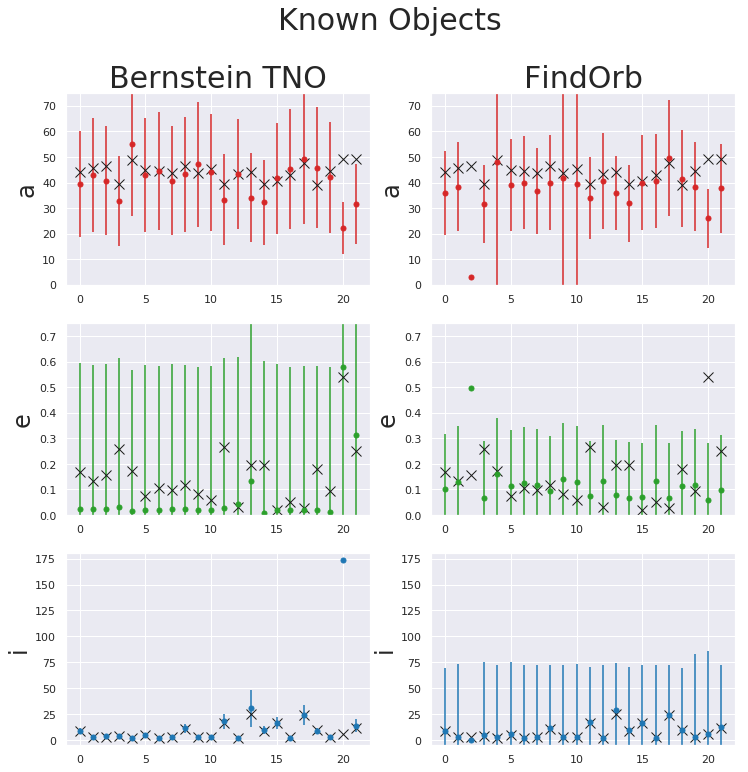

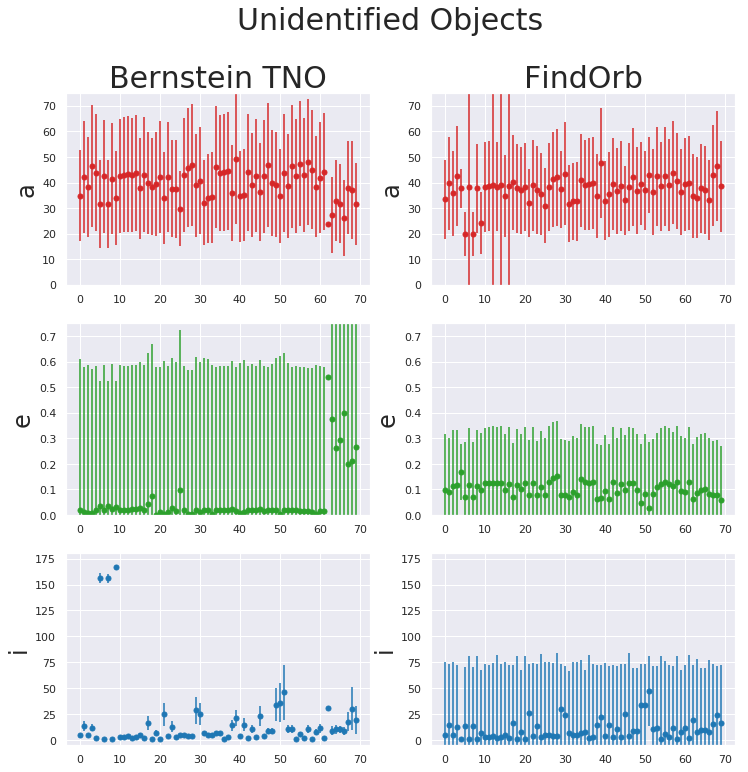

In [6]:
sns.set()
pg_nums, ccd_nums, indexes = load_pg_nums('/epyc/users/smotherh/kbmod_epyc/notebooks/saved_trajectory_images/known_objects/kbmod_stamps')
fo = parse_findorb_results(pg_nums, ccd_nums, indexes)
ber = parse_bernstein_results(pg_nums, ccd_nums, indexes, orbit_dict)
fig, ax = plot_fo_ber_comparison(fo, ber)

a, e, i = load_horizon_orbits('/epyc/users/smotherh/kbmod_epyc/notebooks/saved_trajectory_images/known_objects/kbmod_stamps')
ax[0][0].plot(a,marker='x',ms=10,ls='',color='k')
ax[0][1].plot(a,marker='x',ms=10,ls='',color='k')
ax[1][0].plot(e,marker='x',ms=10,ls='',color='k')
ax[1][1].plot(e,marker='x',ms=10,ls='',color='k')
ax[2][0].plot(i,marker='x',ms=10,ls='',color='k')
ax[2][1].plot(i,marker='x',ms=10,ls='',color='k')

fig.suptitle('Known Objects', fontsize=30)

pg_nums, ccd_nums, indexes = load_pg_nums('/epyc/users/smotherh/kbmod_epyc/notebooks/saved_trajectory_images/unidentified_objects')
fo = parse_findorb_results(pg_nums, ccd_nums, indexes)
ber = parse_bernstein_results(pg_nums, ccd_nums, indexes, orbit_dict)
fig, ax = plot_fo_ber_comparison(fo, ber)
fig.suptitle('Unidentified Objects', fontsize=30)

In [269]:
fig.savefig('BestFitOrbits.png')

The class loads the results file into a pandas dataframe called `results_df`.

## Predict location at other times

### Get coordinates of predictions

Now we can use the code to predict the location of the object at other times. Here we set a date range of 50 days before and after the initial observation in our **KBMOD** search. Then we predict the (ra, dec) for these times before storing them in a pandas dataframe with the time of each predicted location.

In [46]:
date_range = np.arange(ep.mjd_0-50., ep.mjd_0+50., 0.5)
pred_ra, pred_dec = ep.predict_ephemeris(date_range, file_in=None)

# Take this data and turn into a pandas dataframe of predicted observational locations and times
ephem_df = pd.DataFrame(np.array([date_range, pred_ra, pred_dec]).T, columns=['mjd', 'pred_ra', 'pred_dec'])
ephem_df.head()

,mjd,pred_ra,pred_dec
0,56720.213255,216.808722,-11.966674
1,56720.713255,216.803955,-11.964729
2,56721.213255,216.799261,-11.962787
3,56721.713255,216.794326,-11.960792
4,56722.213255,216.789461,-11.958800


### Plot predicted locations

We can also take this data range and plot it with the observations from our search highlighted on the orbit.

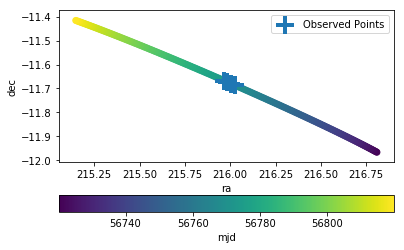

In [47]:
fig = ep.plot_predictions(date_range)

### Get predicted pixel locations in a new image

Take a new image and calculate the predicted pixel locations at given times for the object. Even though we use a single WCS it is useful to get an idea of where an object might be in a sequence of images taken of the same field.

In [48]:
new_image = str('/epyc/users/smotherh/DECAM_Data_Reduction/pointing_groups_hyak/'+
                'Pointing_Group_300/processed_data/rerun/rerun_processed_data/0434610/'+
                'calexp/calexp-0434610_22.fits')

new_times = np.arange(ep.mjd_0+1, ep.mjd_0+1.5, 0.1)

x_pix, y_pix = ep.predict_pixels(new_image, new_times)

# Create a pandas dataframe with the predicted x, y locations
pixel_df = pd.DataFrame(np.array([new_times, x_pix, y_pix]).T, columns=['mjd', 'pred_x_loc', 'pred_y_loc'])
pixel_df.head()

NoConvergence: 'WCS.all_world2pix' failed to converge to the requested accuracy.
After 2 iterations, the solution is diverging at least for one input point.